### 1.0 Import Libraries

In [53]:
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

### 2.0 Use BeautifulSoup and Urlopen to Retrieve Data

In [54]:
url = 'https://www.basketball-reference.com/leagues/NBA_2019_advanced.html'

html = urlopen(url)

soup = BeautifulSoup(html)

### 2.1 Get Headers from DataFrame

In [55]:
# soup.findAll('tr', limit=2) is finding all 'tr' tags, limit=2 ..... And .getText() is pulling the text of 'th'
headers = [th.getText() for th in soup.findAll('tr')[0].findAll('th')]

headers = headers[1:]

### 2.2 Get Data from Rows

In [56]:
rows = soup.findAll('tr')

player_stats_1 = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

### 3.0 Create DataFrame

In [57]:
og_df = pd.DataFrame(data=player_stats_1[1:], columns=headers)

In [58]:
df = og_df.copy()

### 4.0 Convert to Numbers and Drop Unnecessary Columns

In [59]:
df = df.apply(pd.to_numeric, errors='ignore')

In [60]:
df = df.drop(['Pos', 'Age', 'Tm'], axis=1)

In [61]:
# Convert everything but player names to numbers and coerce non-numbers into NaNs
df = df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

In [62]:
# Save list of player names for later
df['Player'] = og_df['Player']

In [63]:
# Drop NaNs and specific columns

# df = df.dropna()

columns_to_keep = ['Player', 'TS%', '3PAr', 'FTr', 'ORB%', 'AST%', 'TOV%', 'USG%']

df = pd.DataFrame(df[columns_to_keep], columns=columns_to_keep)

#df.drop(['FG', 'FGA', 'FG%', '3P', '2P', 'eFG%', 'FT', 'TRB', 'PF',
 #             'DRB', 'FTA', '2PA', '2P%', '3PA', 'GS', 'G', 'FT%'], axis=1)

In [64]:
df = df.dropna()

In [65]:
df.head()

,Player,TS%,3PAr,FTr,ORB%,AST%,TOV%,USG%
0,Álex Abrines,0.507,0.809,0.083,0.9,4.3,7.9,12.2
1,Quincy Acy,0.379,0.833,0.556,2.7,8.2,15.2,9.2
2,Jaylen Adams,0.474,0.673,0.082,2.6,19.8,19.7,13.5
3,Steven Adams,0.591,0.002,0.361,14.7,6.6,12.6,16.4
4,Bam Adebayo,0.623,0.031,0.465,9.2,14.2,17.1,15.8


### (Delete?) 4.1 Convert to Rate Stats

In [66]:
# Divide other columns by df['MP'] to get rate stats
#rate_df = df[['ORB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']].div(df['MP'], axis=0)

In [67]:
#rate_df['3P%'] = df['3P%']

#rate_df['Player'] = df['Player']

### 4.2 Convert Pandas DataFrame into Matrix for Processing

In [68]:
df_as_matrix = df.values

### 5.0 Import and Scale Vectors

In [69]:
from sklearn.preprocessing import scale

In [70]:
scaled_vectors = scale(df_as_matrix[:,1:], axis=0)

/Users/seanmcalevey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### 5.1 Import PCA and Scale to 3 Dims

In [71]:
from sklearn.decomposition import PCA

In [72]:
n_components = 3

pca = PCA(n_components)

In [73]:
dim_reduction = pca.fit_transform(scaled_vectors)

In [74]:
print('Retained Info: ' + str(round(100*sum(pca.explained_variance_ratio_),3)) + '%')

Retained Info: 62.422%


### 5.2 Import KMeans for Clustering

In [75]:
from sklearn.cluster import KMeans

In [76]:
num_of_clusters = 10

cluster = KMeans(num_of_clusters)

In [77]:
clusters = cluster.fit_predict(dim_reduction)

In [78]:
reduced_df = df.copy()

reduced_df['Cluster'] = clusters

reduced_df = reduced_df.reset_index()

In [79]:
reduced_df['PCA1'] = [dim_reduction[x][0] for x in range(len(dim_reduction))]

reduced_df['PCA2'] = [dim_reduction[x][1] for x in range(len(dim_reduction))]

reduced_df['PCA3'] = [dim_reduction[x][2] for x in range(len(dim_reduction))]

### 5.3 Get Averages for Each Cluster

In [80]:
averages_dict = {}

for cluster in range(num_of_clusters):
    temp_df = pd.DataFrame(columns=reduced_df.columns)
    for index in range(len(reduced_df)):
        if reduced_df['Cluster'][index] == cluster:
            temp_df = temp_df.append(reduced_df.iloc[index, :])
    averages_dict[cluster] = np.mean(temp_df)

In [81]:
averages_df = pd.DataFrame(columns=reduced_df.columns)

for i in range(num_of_clusters):
    averages_df = averages_df.append(averages_dict[i], ignore_index=True)

In [82]:
averages_df = averages_df.drop('index', axis=1)

averages_df = round(averages_df, 2)

In [83]:
averages_df = averages_df.drop('Player', axis=1)

### 5.4 Averages DF

In [84]:
averages_df.sort_values('USG%', ascending=False)

,TS%,3PAr,FTr,ORB%,AST%,TOV%,USG%,Cluster,PCA1,PCA2,PCA3
8,0.29,0.00,0.67,66.43,37.97,0.00,36.87,8.0,8.06,-0.87,0.26
1,0.57,0.29,0.30,3.61,29.34,12.39,27.69,1.0,1.42,1.75,-1.17
5,0.49,0.40,0.20,2.48,20.65,14.35,20.40,5.0,0.01,1.15,0.05
9,0.55,0.40,0.23,3.83,11.61,9.33,19.83,9.0,-0.19,-0.14,-0.51
0,0.61,0.06,0.48,11.53,9.59,12.79,18.51,0.0,1.93,-1.35,0.25
2,0.52,0.21,0.32,7.49,10.59,14.57,17.64,2.0,0.72,-0.42,0.69
6,0.33,0.40,0.10,4.64,13.50,29.50,16.13,6.0,-0.38,1.70,3.17
3,0.55,0.62,0.15,2.31,7.11,7.40,15.98,3.0,-1.58,-0.51,-0.53
4,0.48,0.52,0.17,3.82,8.61,12.23,14.09,4.0,-1.17,-0.26,0.56
7,1.50,1.00,0.00,0.00,4.95,0.00,8.15,7.0,-2.91,-3.75,-5.93


### 6.0 Graph Clusters

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

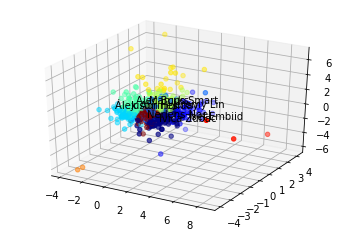

In [86]:
cmap = plt.cm.get_cmap('jet', reduced_df['Cluster'].nunique())

ax = plt.axes(projection='3d')

ax.scatter3D(reduced_df['PCA1'], reduced_df['PCA2'], reduced_df['PCA3'], c=reduced_df['Cluster'], cmap=cmap)

for i, txt in enumerate(reduced_df['Player'].tolist()):
    if i % 100 == 0:
        ax.text(reduced_df['PCA1'][i], reduced_df['PCA2'][i], reduced_df['PCA3'][i], txt)

### 7.0 Optional: Player Locator

In [87]:
# Input player name:

player_name = input('Player name: ')

# Retrieve index of player name:

index = reduced_df['Player'].tolist().index(f'{player_name}')

# Pull player's stats:

player_stats = reduced_df.iloc[index,:]

player_stats = np.asarray(player_stats)

Player name: Kemba Walker


### 7.1 Find L2-Norm of Player's PCA vs. Others

In [88]:
# Loop through and create a list of L2-Norms:

player_diff = []

for i in range(len(reduced_df)):
    pca1, pca2, pca3 = player_stats[10], player_stats[11], player_stats[12]
    ipca1, ipca2, ipca3 = reduced_df['PCA1'][i], reduced_df['PCA2'][i], reduced_df['PCA3'][i]
    total_1 = pca1 - ipca1
    total_2 = pca2 - ipca2
    total_3 = pca3 - ipca3
    l2_norm = np.sqrt(total_1 ** 2 + total_2 ** 2 + total_3 ** 2)
    player_diff += [(i,l2_norm)]

### 7.2 Idenitify Three Best Comp Players

In [89]:
# Initialize:

comp_1, it_1, comp_2, it_2, comp_3, it_3 = [x for x in np.zeros(6) + 3]

# Best Comp:

for i in range(len(player_diff)):
    if (player_diff[i][1] < comp_1) and (player_diff[i][1] > 0):
        comp_1 = player_diff[i][1]
        it_1 = i

# Second Comp:

for i in range(len(player_diff)):
    if (player_diff[i][1] < comp_2) and (player_diff[i][1] > comp_1):
        comp_2 = player_diff[i][1]
        it_2 = i

# Third Comp:

for i in range(len(player_diff)):
    if (player_diff[i][1] < comp_3) and (player_diff[i][1] > comp_1) and (player_diff[i][1] > comp_2):
        comp_3 = player_diff[i][1]
        it_3 = i
        
# Least Comp:

least_comp = 0
it_least = 0

for i in range(len(player_diff)):
    if (player_diff[i][1] > least_comp):
        least_comp = player_diff[i][1]
        it_least = i

print(it_1, it_2, it_3, it_least)

320 399 143 164


### 7.3 Create New DF with Comps

In [90]:
player_comp_df = pd.DataFrame()

player_comp_df['Actual Player'] = reduced_df.iloc[index,1:]
player_comp_df['Top Comp'] = reduced_df.iloc[it_1,1:]
player_comp_df['Second-Best Comp'] = reduced_df.iloc[it_2,1:]
player_comp_df['Third-Best Comp'] = reduced_df.iloc[it_3,1:]

In [91]:
comp_df = pd.DataFrame(np.transpose(player_comp_df.values))

list_of_columns = ['Player'] + list(averages_df.columns)

comp_df.columns = list_of_columns

In [92]:
player_subject = pd.Series(scaled_vectors[index, :])

comp_a = pd.Series(scaled_vectors[it_1, :])
comp_b = pd.Series(scaled_vectors[it_2, :])
comp_c = pd.Series(scaled_vectors[it_3, :])

scaled_array = np.array([player_subject, comp_a, comp_b, comp_c])

new_columns = ['sTS%', 's3PAr', 'sFTr', 'sORB%', 'sAST%', 'sTOV%', 'sUSG%']

for i, column in enumerate(new_columns):
    comp_df[column] = [round(scaled_array[x][i], 2) for x in range(4)]

In [93]:
comp_df['Similarity Score'] = [1, (1 - comp_1/least_comp), (1 - comp_2/least_comp), (1 - comp_3/least_comp)]

In [94]:
comp_df = comp_df.drop(['PCA1', 'PCA2', 'PCA3'], axis=1)

In [95]:
comp_df

,Player,TS%,3PAr,FTr,ORB%,AST%,TOV%,USG%,Cluster,sTS%,s3PAr,sFTr,sORB%,sAST%,sTOV%,sUSG%,Similarity Score
0,Kemba Walker,0.558,0.434,0.267,1.9,29.4,10.1,31.5,1,0.23,0.25,0.10,-0.52,1.83,-0.34,2.36,1.000000
1,Kyrie Irving,0.592,0.35,0.197,3.4,35,11.3,29.6,1,0.53,-0.14,-0.30,-0.27,2.46,-0.13,2.01,0.965522
2,Damian Lillard,0.588,0.419,0.335,2.6,30.6,10.8,29.3,1,0.50,0.18,0.48,-0.41,1.96,-0.22,1.96,0.965375
3,Mike Conley,0.569,0.38,0.363,1.9,33.4,9.1,27.3,1,0.33,-0.00,0.64,-0.52,2.28,-0.52,1.59,0.962805
